In [22]:
import numpy as np
from defs import Box, Point
from scipy.optimize import differential_evolution, Bounds, NonlinearConstraint
import matplotlib.pyplot as plt
from typing import Tuple, List
from math import sqrt
from statistics import variance

In [7]:
def get_norm_distance_from_image_edges(
    canvas_shape: Tuple[int, int], box: Box
) -> List[float]:

    canvas_diag_length = sqrt(canvas_shape[0] ** 2 + canvas_shape[1] ** 2)

    distance_edge_1 = box.vertex_1.x / canvas_diag_length
    distance_edge_2 = (canvas_shape[1] - box.vertex_3.x) / canvas_diag_length
    distance_edge_3 = box.vertex_1.y / canvas_diag_length
    distance_edge_4 = (canvas_shape[0] - box.vertex_3.y) / canvas_diag_length

    return [distance_edge_1, distance_edge_2, distance_edge_3, distance_edge_4]

def get_overlapping_area(box_1: Box, box_2: Box) -> int:

    if not box_1.is_overlapping(box_2):
        return 0

    # make overlap box
    x1 = max(box_1.vertex_1.x, box_2.vertex_1.x)
    y1 = max(box_1.vertex_1.y, box_2.vertex_1.y)
    x3 = min(box_1.vertex_3.x, box_2.vertex_3.x)
    y3 = min(box_1.vertex_3.y, box_2.vertex_3.y)

    try:
        return Box(
            first_diagonal_coords=Point((x1, y1)),
            second_diagonal_coords=Point((x3, y3)),
        ).area
    except AssertionError:
        # there are only 2 cases when the above fail -
        # if the two boxes touch each other with a line or a point
        return 0

In [302]:
persons = (
    	Box(first_diagonal_coords=Point(coords=(10, 20)), second_diagonal_coords=Point(coords=(40, 60))),
    	Box(first_diagonal_coords=Point(coords=(65, 10)), second_diagonal_coords=Point(coords=(85, 30))),
    	Box(first_diagonal_coords=Point(coords=(50, 70)), second_diagonal_coords=Point(coords=(70, 90)))
    )

In [303]:
canvas = np.ones([100,100])

In [304]:
for person in persons:
    canvas = person.overlay_on_image(canvas)

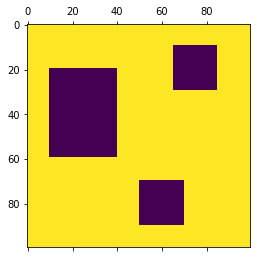

In [305]:
plt.matshow(canvas)

In [55]:
def get_constraints(
    canvas_height: int, canvas_width: int
) -> Tuple[NonlinearConstraint, ...]:

    # these constraints emulate the behaviour of `is_box_big_enough` function
    min_box_width_constraint = lambda x: (x[2] - x[0])
    min_box_height_constraint = lambda x: (x[3] - x[1])
    nlc3 = NonlinearConstraint(
        min_box_width_constraint, 0.25 * canvas_width, canvas_width
    )
    nlc4 = NonlinearConstraint(
        min_box_height_constraint, 0.10 * canvas_height, canvas_height
    )

    # this is to signal the solver that every tried-solution (i.e. `x`) in a population
    # and for every iteration (`generation` in case of DE) should be very close to an integer
    # currently it is not being used as it slows down the opti
    # integer_coords_constraint = lambda x: sum(abs(np.round(x) - x))
    # nlc6 = NonlinearConstraint(integer_coords_constraint, -1e-6, 1e-6)

    return nlc3, nlc4

In [56]:
limits = (
            (0, canvas.shape[1]),
            (0, canvas.shape[0]),
            (0, canvas.shape[1]),
            (0, canvas.shape[0]),
        )        

In [294]:
class LossFunctionParameters:
    OVERLAP_WEIGHTAGE: float = 0.5
    MIN_DISTANCE_WEIGHTAGE: float = 0.4
    UNIFORM_DISTANCE_WEIGHTAGE: float = 0.05
    BOX_AREA_WEIGHTAGE: float = 0.05
#     MAXIMUM_LOSS_THRESHOLD: float = 3

In [295]:
def get_loss(
    x, canvas_shape: Tuple[int, int], forbidden_zones: Tuple[Box, ...]
) -> float:
    lyrics_box = Box(
        first_diagonal_coords=Point(coords=(x[0], x[1])),
        second_diagonal_coords=Point(coords=(x[2], x[3])),
    )

    total_overlapping_area = sum(
        [
            get_overlapping_area(lyrics_box, zone)
            / (canvas_shape[0] * canvas_shape[1])
            for zone in forbidden_zones
        ]
    )

    # # include the following:
    # # distance from all person-boxes - w1

    # # iterate over all the edges of all person-boxes and find the distances of them from the lyrics-box
    if len(forbidden_zones):
        norm_distance_persons = tuple(
            [
                lyrics_box.get_distance_from(zone)
                / sqrt(canvas_shape[0] ** 2 + canvas_shape[1] ** 2)
                for zone in forbidden_zones
            ]
        )
    else:
        norm_distance_persons = tuple([])

    # # distance from all 4 edges - w2
    norm_distance_edges = get_norm_distance_from_image_edges(canvas_shape, lyrics_box)

    all_norm_distances = tuple(norm_distance_edges) + norm_distance_persons

    norm_lyrics_box_area = lyrics_box.area / (canvas_shape[0] * canvas_shape[1])
        
    min_norm_distance_persons = 1e-6 if min(all_norm_distances) == 0 else min(all_norm_distances)

    return (
        LossFunctionParameters.UNIFORM_DISTANCE_WEIGHTAGE * sqrt(variance(all_norm_distances))
        + LossFunctionParameters.BOX_AREA_WEIGHTAGE * (1 / sqrt(norm_lyrics_box_area))
        + LossFunctionParameters.OVERLAP_WEIGHTAGE * sqrt(total_overlapping_area)
        + LossFunctionParameters.MIN_DISTANCE_WEIGHTAGE / min_norm_distance_persons
    )

In [306]:
res = differential_evolution(
                get_loss,
                bounds=limits,
                args=(canvas.shape, persons),
                popsize=15,
                constraints=get_constraints(canvas.shape[0], canvas.shape[1]),
                disp=True
            )

differential_evolution step 1: f(x)= 400000
differential_evolution step 2: f(x)= 28.4635
differential_evolution step 3: f(x)= 28.4635
differential_evolution step 4: f(x)= 28.4635
differential_evolution step 5: f(x)= 19.089
differential_evolution step 6: f(x)= 9.69794
differential_evolution step 7: f(x)= 9.69794
differential_evolution step 8: f(x)= 9.69794
differential_evolution step 9: f(x)= 5.40834
differential_evolution step 10: f(x)= 4.99746
differential_evolution step 11: f(x)= 4.99746
differential_evolution step 12: f(x)= 4.99149
differential_evolution step 13: f(x)= 4.99149
differential_evolution step 14: f(x)= 4.99149
differential_evolution step 15: f(x)= 4.35135
differential_evolution step 16: f(x)= 4.315
differential_evolution step 17: f(x)= 4.315
differential_evolution step 18: f(x)= 4.315
differential_evolution step 19: f(x)= 4.315
differential_evolution step 20: f(x)= 4.315
differential_evolution step 21: f(x)= 4.315
differential_evolution step 22: f(x)= 4.315
differential_

In [307]:
optimal_box = Box(first_diagonal_coords=Point((res.x[0], res.x[1])),
                  second_diagonal_coords=Point((res.x[2], res.x[3])))

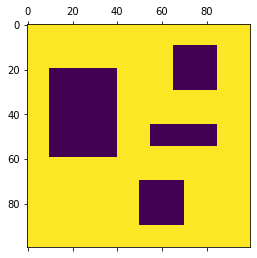

In [308]:
plt.matshow(optimal_box.overlay_on_image(canvas))